In [18]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
from Tools.plotting import CandlePlot
import pandas_ta as ta

In [19]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../DB/15m/INJUSDT_15m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [20]:
class BBands:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
            BB_window = 100,
            BB_std = 2.25,
            max_BB_speard = 0,
            ma_window = 40) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.BB_window = BB_window
        self.BB_std = BB_std
        self.max_BB_spread = max_BB_speard
        self.ma_window = ma_window
        self.trades = pd.DataFrame()

    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        
        # -- Populate indicators --
        mult = 0.1
        df['ma_band'] = df['close'].ewm(span=40, adjust=False).mean()
        df['slow_ma'] = df['close'].ewm(span=40*4, adjust=False).mean()
        df['dev'] =  df['close'].rolling(window=1000).std()
        df['lvl_above'] = df['ma_band'] + df['dev']  * mult
        df['lvl_below'] = df['ma_band'] - df['dev']  * mult


        
        df = get_n_columns(df, ["lvl_above",  "lvl_below", "ma_band", 'close'], 1)
        
        self.df = df    
        return self.df
    
    def generate_signals(self):
        df = self.df

        df['buy_condition'] = False
        df['sell_condition'] = False
        df['close_buy_condition'] = False
        df['close_sell_condition'] = False

        df['long_short'] = (df['slow_ma'] > df['lvl_below']) & (df['slow_ma'] < df['lvl_above'])
        df['long'] = (df['slow_ma'] < df['lvl_below']) | df['long_short']
        df['short'] = (df['slow_ma'] > df['lvl_above']) | df['long_short']

        df['buy_condition'] = (df['close'] > df['lvl_below']) & (df['n1_close'] < df['lvl_below']) & df['long']
        df['sell_condition'] = (df['close'] < df['lvl_above']) & (df['n1_close'] > df['lvl_above']) & df['short']
        df['close_buy_condition'] = (df['close'] > df['ma_band']) #| (df['close'] < df['LSL'])
        df['close_sell_condition'] = (df['close'] < df['ma_band'])# | (df['close'] > df['SSL'])

        self.df = df    
        return self.df



    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                df['buy_condition'] == True
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                df['close_buy_condition'] == True
                , f"close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                df['sell_condition'] ==True
                
                , "open_short_market"
            ] = True
            
            # -- Populate close short market --
            df.loc[
                df['close_sell_condition'] == True 
                , "close_short_market"
            ] = True
               
        self.df = df   
        return self.df

    # Running the backtest
    
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }
    
    def plot(self, win):
        
        dfplt = self.df[win:win+1000]
        cp = CandlePlot(dfplt)
            # Find the date range in dfplt
        start_date = dfplt.index.min()  # assuming dfplt index is datetime
        end_date = dfplt.index.max()
        
        # Filter trades within the date range of dfplt
        trades_in_range = self.trades[
            ((self.trades['open_date'] >= start_date) & (self.trades['open_date'] <= end_date)) |
            ((self.trades['close_date'] >= start_date) & (self.trades['close_date'] <= end_date))
        ]
        cp.add_traces(['lvl_above', 'lvl_below', 'ma_band', 'slow_ma'])
        cp.add_entries(trades_in_range)
        cp.show_plot()

In [21]:
strat = BBands(df_t)

In [22]:
strat.populate_indicators()
strat.generate_signals()
strat.populate_buy_sell()
# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])


Period: [2022-11-21 00:00:00] -> [2024-09-03 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 186.97 $
Performance vs US dollar: -81.3 %
Sharpe Ratio: -1.53
Worst Drawdown T|D: -85.4% | -85.17%
Buy and hold performance: 996.42 %
Performance vs buy and hold: -98.29 %
Total trades on the period: 1585
Global Win rate: 65.17 %
Average Profit: -0.09 %
Total fees paid 1315.87$

Best trades: +10.29 % the 2023-08-17 21:00:00 -> 2023-08-17 21:30:00
Worst trades: -21.48 % the 2023-12-13 15:30:00 -> 2023-12-14 09:45:00


In [23]:
strat.plot(-2000)

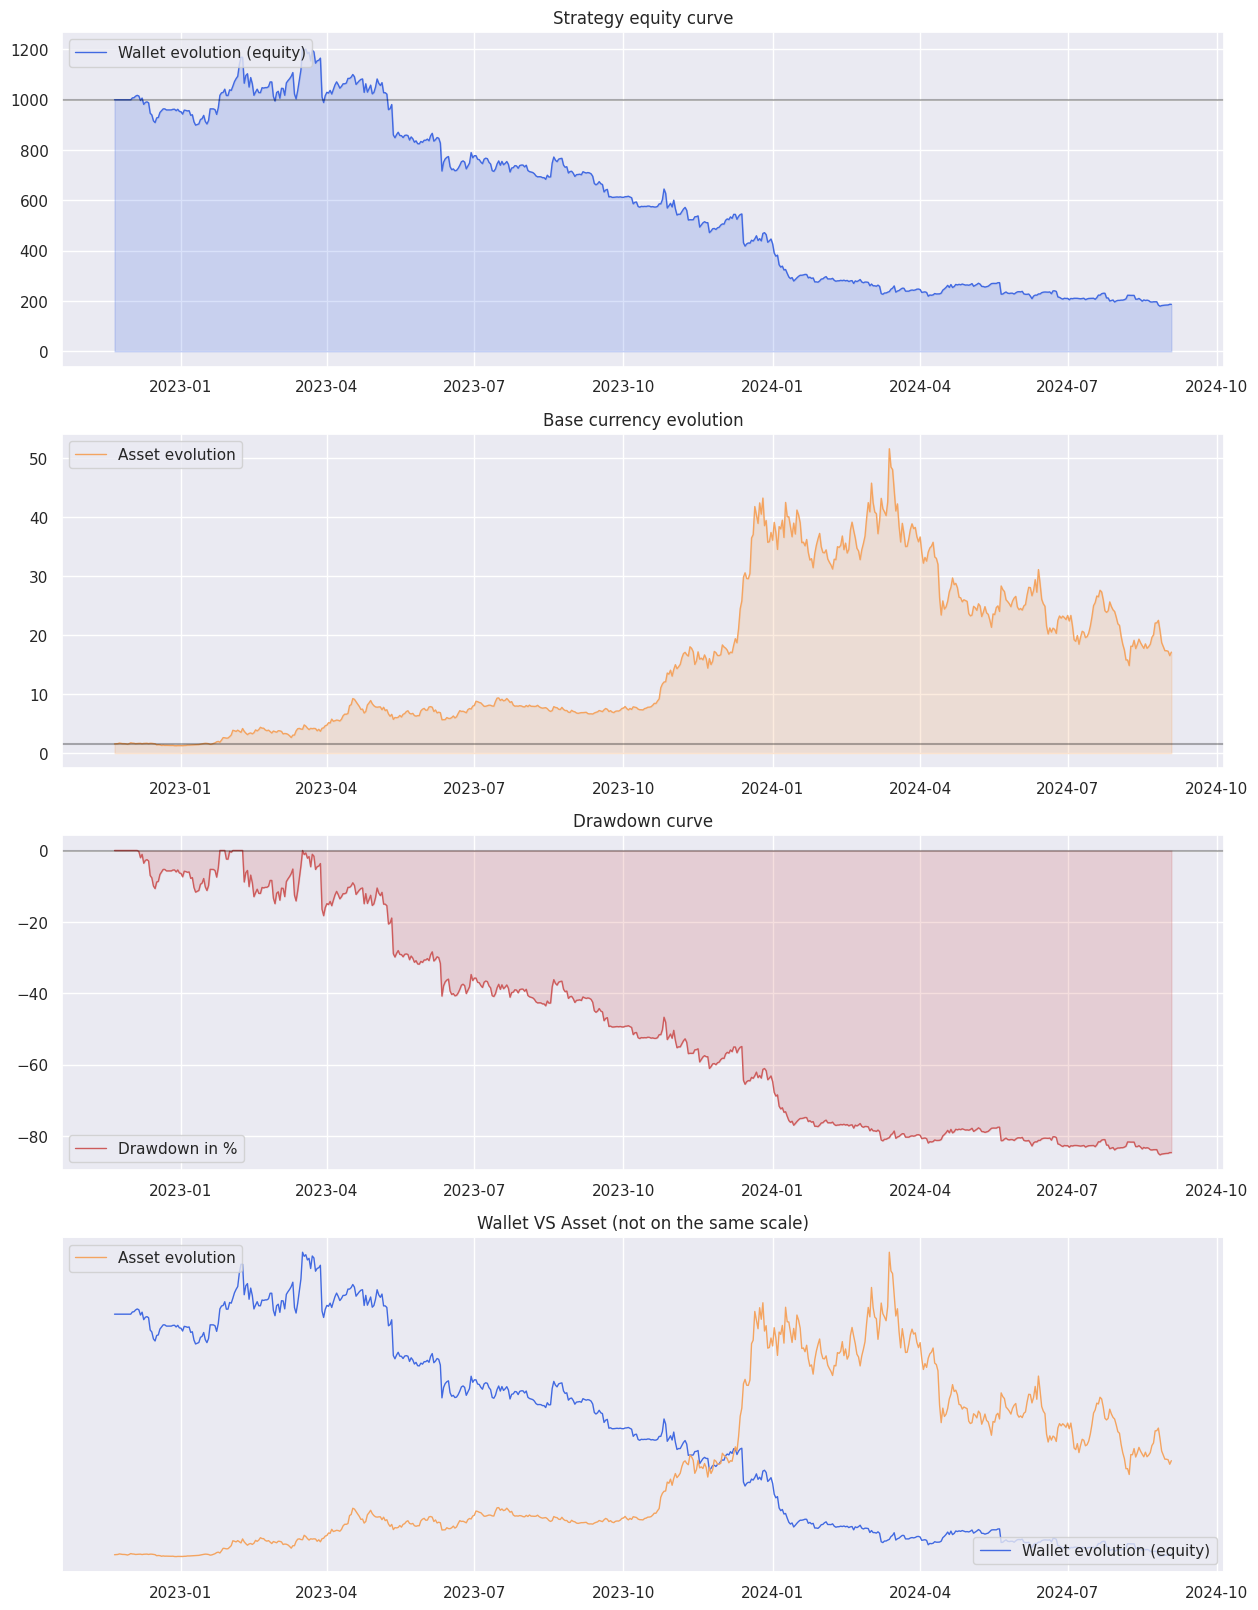

In [24]:
plot_wallet_vs_asset(df_days=df_days)

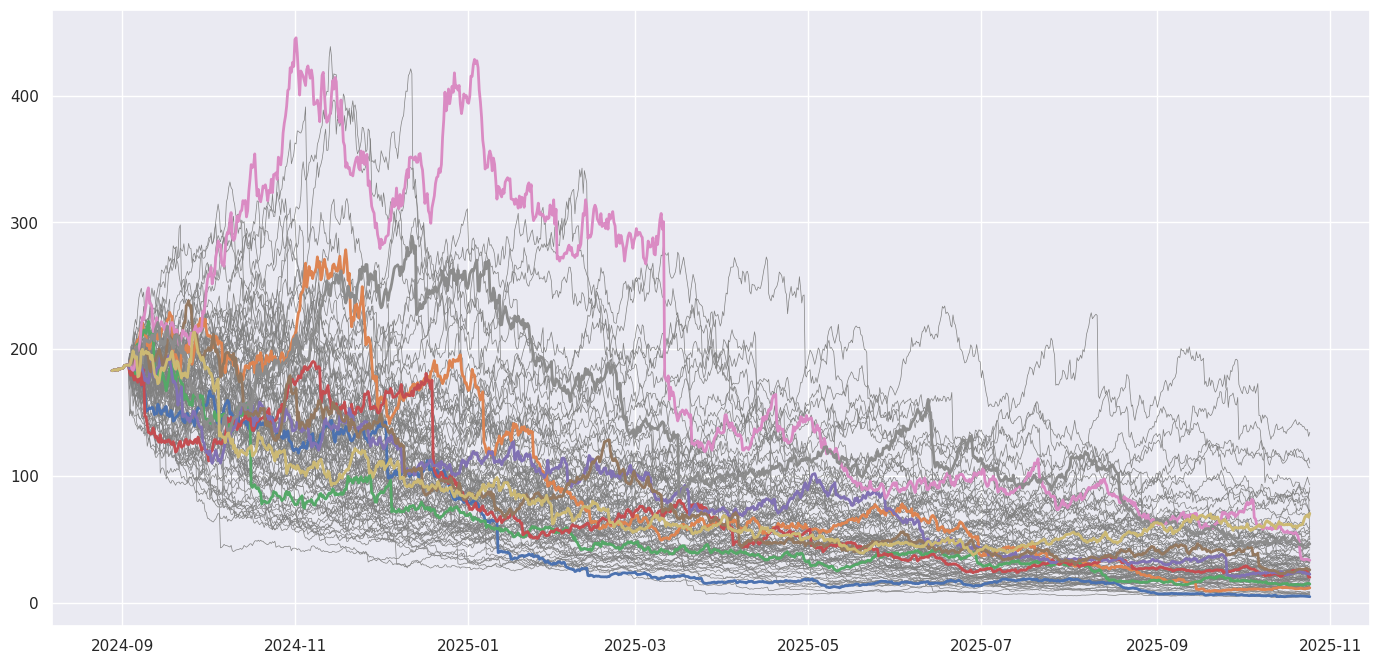

In [25]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=1,
    trades_to_forecast=1000,
    number_of_simulations=100,
    true_trades_to_show=10,
    show_all_simulations=True,
)

----- 2022 Cumulative Performances: -4.63% -----


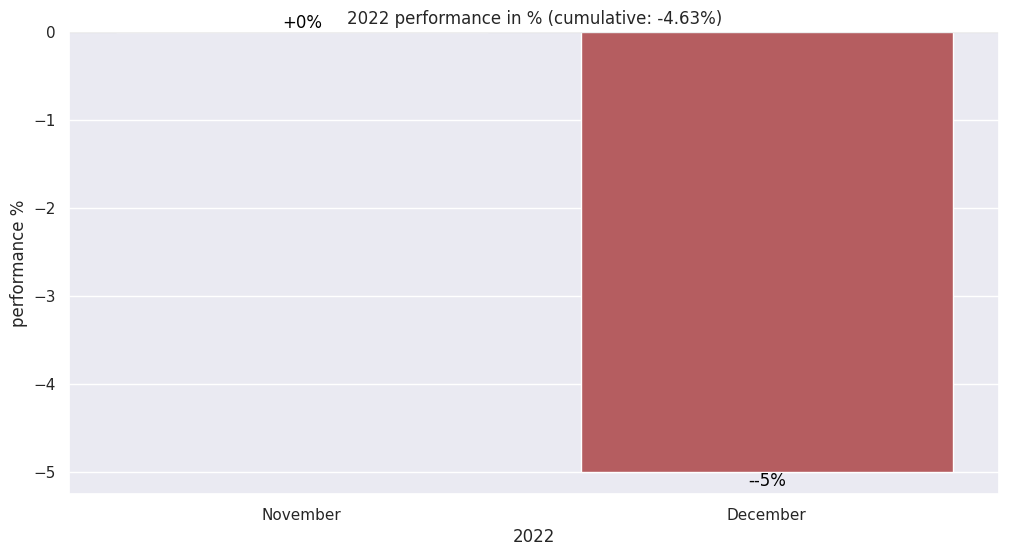

----- 2023 Cumulative Performances: -53.12% -----


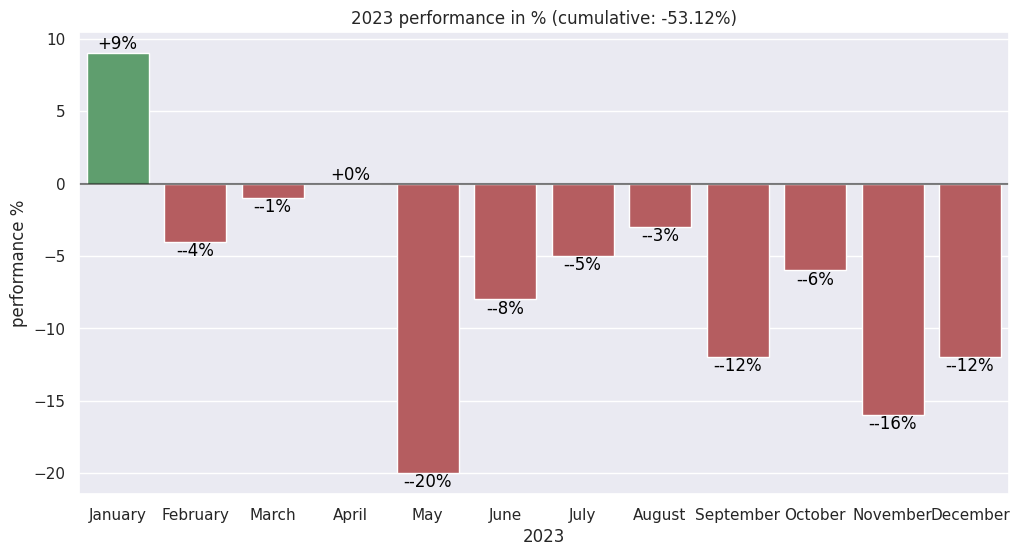

----- 2024 Cumulative Performances: -56.24% -----


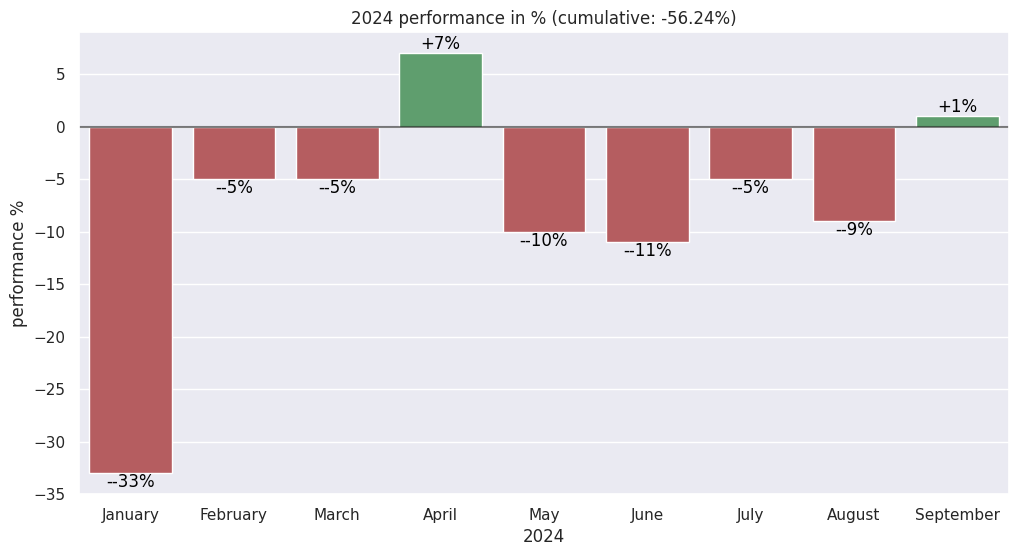

In [26]:
plot_bar_by_month(df_days=df_days)